In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=50, grid_bounds=[(0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    
model = GPRegressionModel()

In [4]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

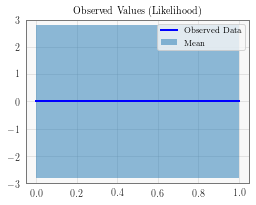

In [5]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [6]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(30):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

Iter 1/30 - Loss: 1.153
Iter 2/30 - Loss: 1.122
Iter 3/30 - Loss: 1.092
Iter 4/30 - Loss: 1.065
Iter 5/30 - Loss: 1.034
Iter 6/30 - Loss: 1.009
Iter 7/30 - Loss: 0.983
Iter 8/30 - Loss: 0.959
Iter 9/30 - Loss: 0.931
Iter 10/30 - Loss: 0.897
Iter 11/30 - Loss: 0.853
Iter 12/30 - Loss: 0.801
Iter 13/30 - Loss: 0.718
Iter 14/30 - Loss: 0.628
Iter 15/30 - Loss: 0.531
Iter 16/30 - Loss: 0.443
Iter 17/30 - Loss: 0.357
Iter 18/30 - Loss: 0.288
Iter 19/30 - Loss: 0.238
Iter 20/30 - Loss: 0.173
Iter 21/30 - Loss: 0.132
Iter 22/30 - Loss: 0.094
Iter 23/30 - Loss: 0.053
Iter 24/30 - Loss: 0.006
Iter 25/30 - Loss: -0.019
Iter 26/30 - Loss: -0.039
Iter 27/30 - Loss: -0.071
Iter 28/30 - Loss: -0.089
Iter 29/30 - Loss: -0.103
Iter 30/30 - Loss: -0.110


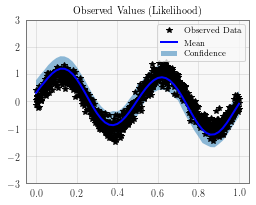

In [7]:
model.condition(train_x, train_y)
f = plot_model_and_predictions(model, plot_train_data=True)